# Detect data bias with Amazon SageMaker Clarify

First, let's install and import required modules.

In [2]:
# please ignore warning messages during the installation
!pip install --disable-pip-version-check -q sagemaker==2.35.0
!pip install -q protobuf==3.20.*

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
distributed 2022.7.0 requires tornado<6.2,>=6.0.3, but you have tornado 6.4 which is incompatible.

[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip


In [3]:
import boto3
import sagemaker
import pandas as pd
import numpy as np
import botocore

config = botocore.config.Config(user_agent_extra='dlai-pds/c1/w2')

# low-level service client of the boto3 session
sm = boto3.client(service_name='sagemaker', 
                  config=config)

sess = sagemaker.Session(sagemaker_client=sm)

bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
region = sess.boto_region_name

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

<a name='c1w2-1.'></a>
# 1. Analyze the dataset

<a name='c1w2-1.1.'></a>
### 1.1. Create a pandas data frame from the CSV file

Create a pandas dataframe from each of the product categories and concatenate them into one.

In [5]:
!aws s3 cp 's3://dlai-practical-data-science/data/transformed/womens_clothing_ecommerce_reviews_transformed.csv' ./

download: s3://dlai-practical-data-science/data/transformed/womens_clothing_ecommerce_reviews_transformed.csv to ./womens_clothing_ecommerce_reviews_transformed.csv


In [6]:
path = './womens_clothing_ecommerce_reviews_transformed.csv'

df = pd.read_csv(path)
df.head()

,sentiment,review_body,product_category
0,1,If this product was in petite i would get the...,Blouses
1,1,Love this dress! it's sooo pretty. i happene...,Dresses
2,0,I had such high hopes for this dress and reall...,Dresses
3,1,I love love love this jumpsuit. it's fun fl...,Pants
4,1,This shirt is very flattering to all due to th...,Blouses


As you saw in the previous lab, there are way more positive reviews than negative or neutral. Such a dataset is called unbalanced. 

In this case, using a relatively small data subset you could visualize the occurring unbalances. At scale, you would need to perform bias analysis. Let's use this dataset as an example.

/opt/conda/lib/python3.10/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


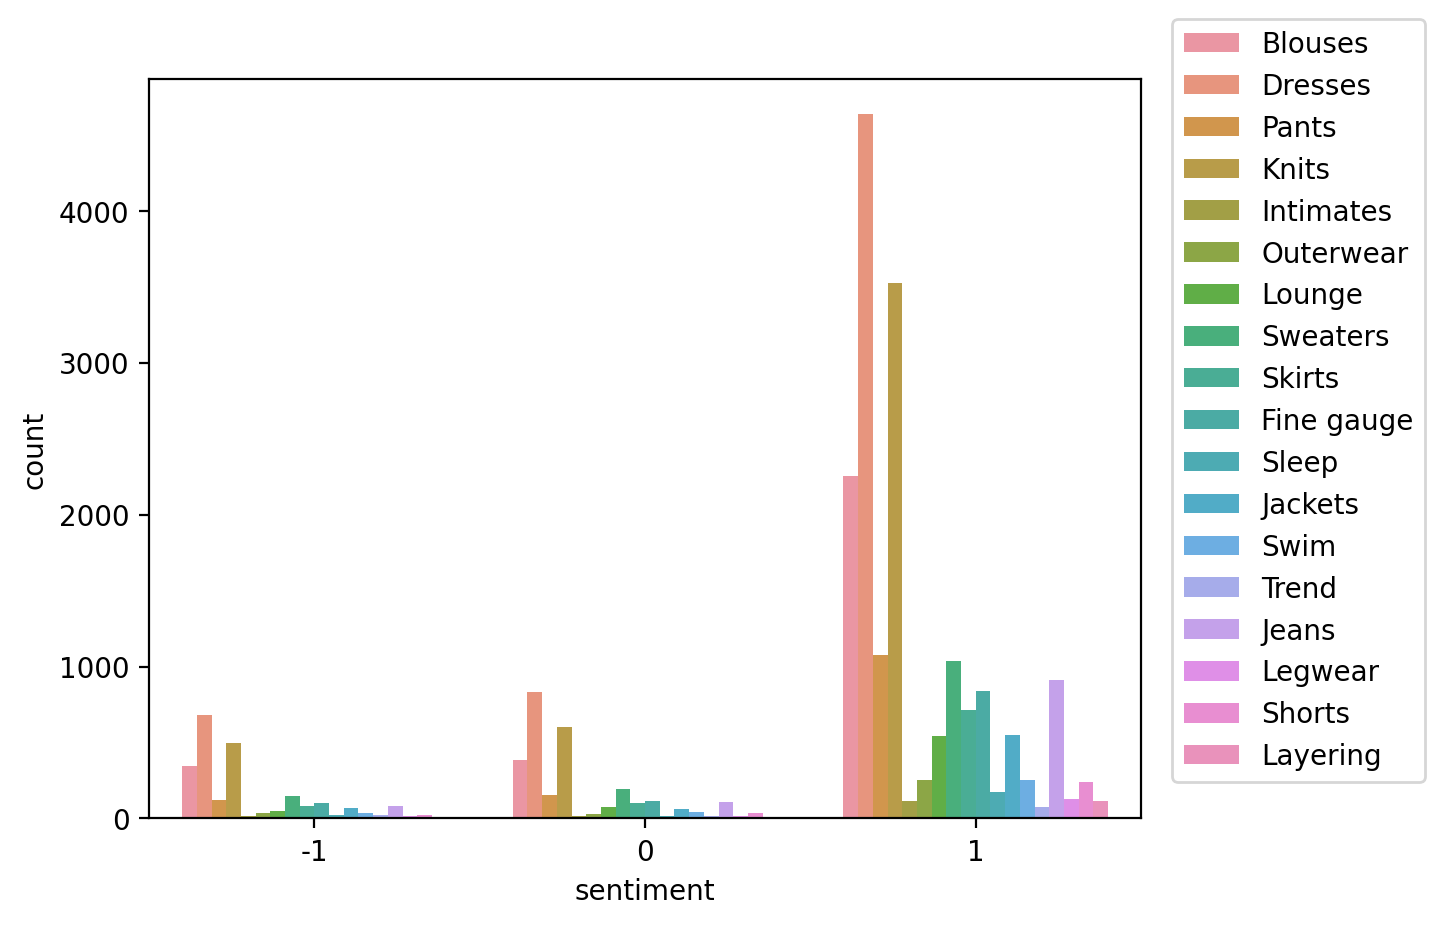

In [7]:
import seaborn as sns

sns.countplot(data=df, x='sentiment', hue='product_category')

plt.legend(loc='upper right',bbox_to_anchor=(1.3, 1.1))

<a name='c1w2-1.2.'></a>
### 1.2. Upload the dataset to S3 bucket

Upload the dataset to a private S3 bucket in a folder called `bias/unbalanced`.

In [8]:
data_s3_uri_unbalanced = sess.upload_data(bucket=bucket, 
                               key_prefix='bias/unbalanced', 
                               path='./womens_clothing_ecommerce_reviews_transformed.csv')
data_s3_uri_unbalanced

's3://sagemaker-us-east-1-096488525855/bias/unbalanced/womens_clothing_ecommerce_reviews_transformed.csv'

You can review the uploaded CSV file in the S3 bucket.

**Instructions**: 
- open the link
- click on the S3 bucket name `sagemaker-us-east-1-ACCOUNT`
- go to the folder `bias/unbalanced`
- check the existence of the file `womens_clothing_ecommerce_reviews_transformed.csv`

In [9]:
from IPython.core.display import display, HTML

display(HTML('<b>Review <a target="top" href="https://s3.console.aws.amazon.com/s3/home?region={}#">Amazon S3 bucket</a></b>'.format(region)))

/tmp/ipykernel_18/1620809557.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


<a name='c1w2-2.'></a>
# 2. Analyze class imbalance on the dataset with Amazon SageMaker Clarify
Let's analyze bias in `sentiment` with respect to the `product_category` facet on the dataset.

<a name='c1w2-2.1.'></a>
### 2.1. Configure a `DataConfig`

Information about the input data needs to be provided to the processor. This can be done with the `DataConfig` of the Clarify container. It stores information about the dataset to be analyzed, for example the dataset file, its format, headers and labels.

In [10]:
from sagemaker import clarify

bias_report_unbalanced_output_path = 's3://{}/bias/generated_bias_report/unbalanced'.format(bucket)

data_config_unbalanced = clarify.DataConfig(
    ### BEGIN SOLUTION - DO NOT delete this comment for grading purposes
    s3_data_input_path=data_s3_uri_unbalanced, # Replace None
    s3_output_path=bias_report_unbalanced_output_path, # Replace None
    label='sentiment', # Replace None
    ### END SOLUTION - DO NOT delete this comment for grading purposes
    headers=df.columns.to_list(),
    dataset_type='text/csv'
)

<a name='c1w2-2.2.'></a>
### 2.2. Configure `BiasConfig`
Bias is measured by calculating a metric and comparing it across groups. To compute it, you will specify the required information in the `BiasConfig` API. SageMaker Clarify needs the sensitive columns (`facet_name`) and the desirable outcomes (`label_values_or_threshold`). Here `product_category` is the sensitive facet and the desired outcome is with the `sentiment==1`.


SageMaker Clarify can handle both categorical and continuous data for `label_values_or_threshold`. In this case you are using categorical data.

In [11]:
bias_config_unbalanced = clarify.BiasConfig(
    label_values_or_threshold=[1], # desired sentiment
    facet_name='product_category' # sensitive column (facet)
)

<a name='c1w2-2.3.'></a>
### 2.3. Configure Amazon SageMaker Clarify as a processing job

Now you need to construct an object called `SageMakerClarifyProcessor`. This allows you to scale the process of data bias detection using two parameters, `instance_count` and `instance_type`. `Instance_count` represents how many nodes you want in the distributor cluster during the data detection. `Instance_type` specifies the processing capability (compute capacity, memory capacity) available for each one of those nodes. For the purposes of this lab, you will use a relatively small instance type. Please refer to [this](https://aws.amazon.com/sagemaker/pricing/) link for additional instance types that may work for your use case outside of this lab.

In [13]:
clarify_processor_unbalanced = clarify.SageMakerClarifyProcessor(role=role,
                                                      instance_count=1,
                                                      instance_type='ml.m5.large',
                                                      sagemaker_session=sess)

<a name='c1w2-2.4.'></a>
### 2.4. Run the Amazon SageMaker Clarify processing job

In [14]:
clarify_processor_unbalanced.run_pre_training_bias(
    ### BEGIN SOLUTION - DO NOT delete this comment for grading purposes
    data_config=data_config_unbalanced, # Replace None
    data_bias_config=bias_config_unbalanced, # Replace None
    ### END SOLUTION - DO NOT delete this comment for grading purposes
    methods=["CI", "DPL", "KL", "JS", "LP", "TVD", "KS"],
    wait=False,
    logs=False
)


Job Name:  Clarify-Pretraining-Bias-2023-12-30-05-28-59-152
Inputs:  [{'InputName': 'dataset', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-east-1-096488525855/bias/unbalanced/womens_clothing_ecommerce_reviews_transformed.csv', 'LocalPath': '/opt/ml/processing/input/data', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}, {'InputName': 'analysis_config', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-east-1-096488525855/bias/generated_bias_report/unbalanced/analysis_config.json', 'LocalPath': '/opt/ml/processing/input/config', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}]
Outputs:  [{'OutputName': 'analysis_result', 'AppManaged': False, 'S3Output': {'S3Uri': 's3://sagemaker-us-east-1-096488525855/bias/generated_bias_report/unbalanced', 'LocalPath': '/opt/ml/processing/output', 'S3UploadMode': 'EndOfJob'}

In [15]:
run_unbalanced_bias_processing_job_name = clarify_processor_unbalanced.latest_job.job_name
print(run_unbalanced_bias_processing_job_name)

Clarify-Pretraining-Bias-2023-12-30-05-28-59-152


<a name='c1w2-2.5.'></a>
### 2.5. Run and review the Amazon SageMaker Clarify processing job on the unbalanced dataset

Review the created Amazon SageMaker Clarify processing job and the Cloud Watch logs.

**Instructions**: 
- open the link
- note that you are in the section Amazon SageMaker -> Processing jobs
- check the processing job name
- note which other properties of the processing job you can see in the console

In [16]:
from IPython.core.display import display, HTML

display(HTML('<b>Review <a target="blank" href="https://console.aws.amazon.com/sagemaker/home?region={}#/processing-jobs/{}">processing job</a></b>'.format(region, run_unbalanced_bias_processing_job_name)))


/tmp/ipykernel_18/4148600592.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [17]:
from IPython.core.display import display, HTML

display(HTML('<b>Review <a target="blank" href="https://console.aws.amazon.com/cloudwatch/home?region={}#logStream:group=/aws/sagemaker/ProcessingJobs;prefix={};streamFilter=typeLogStreamPrefix">CloudWatch logs</a> after about 5 minutes</b>'.format(region, run_unbalanced_bias_processing_job_name)))

/tmp/ipykernel_18/611688307.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [18]:
running_processor = sagemaker.processing.ProcessingJob.from_processing_name(processing_job_name=run_unbalanced_bias_processing_job_name,
                                                                            sagemaker_session=sess)

In [19]:
%%time

running_processor.wait(logs=False)

............................................................................!CPU times: user 231 ms, sys: 31.4 ms, total: 262 ms
Wall time: 6min 25s


<a name='c1w2-2.6.'></a>
### 2.6. Analyze unbalanced bias report
In this run, you analyzed bias for `sentiment` relative to the `product_category` for the unbalanced data. Let's have a look at the bias report.

List the files in the output path `bias_report_unbalanced_output_path`:

In [20]:
!aws s3 ls $bias_report_unbalanced_output_path/

2023-12-30 05:35:23      31732 analysis.json
2023-12-30 05:29:00        346 analysis_config.json
2023-12-30 05:35:23    1255560 report.html
2023-12-30 05:35:23     995353 report.ipynb
2023-12-30 05:35:23     871302 report.pdf


Download generated bias report from S3 bucket:

In [21]:
!aws s3 cp --recursive $bias_report_unbalanced_output_path ./generated_bias_report/unbalanced/

download: s3://sagemaker-us-east-1-096488525855/bias/generated_bias_report/unbalanced/analysis_config.json to generated_bias_report/unbalanced/analysis_config.json
download: s3://sagemaker-us-east-1-096488525855/bias/generated_bias_report/unbalanced/analysis.json to generated_bias_report/unbalanced/analysis.json
download: s3://sagemaker-us-east-1-096488525855/bias/generated_bias_report/unbalanced/report.pdf to generated_bias_report/unbalanced/report.pdf
download: s3://sagemaker-us-east-1-096488525855/bias/generated_bias_report/unbalanced/report.ipynb to generated_bias_report/unbalanced/report.ipynb
download: s3://sagemaker-us-east-1-096488525855/bias/generated_bias_report/unbalanced/report.html to generated_bias_report/unbalanced/report.html


Review the downloaded bias report (in HTML format):

In [22]:
from IPython.core.display import display, HTML

display(HTML('<b>Review <a target="blank" href="./generated_bias_report/unbalanced/report.html">unbalanced bias report</a></b>'))

/tmp/ipykernel_18/1226261498.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


The bias report shows a number of metrics, but here you can focus on just two of them: 
- Class Imbalance (CI). Measures the imbalance in the number of members between different facet values. Answers the question, does a `product_category` have disproportionately more reviews than others? Values of CI will become equal for even distribution between facets. Here, different CI values show the existence of imbalance.
- Difference in Positive Proportions in Labels (DPL). Measures the imbalance of positive outcomes between different facet values. Answers the question, does a `product_category` have disproportionately higher ratings than others? With the range over the interval from -1 to 1, if there is no bias, you want to see this value as close as possible to zero. Here, non-zero values indicate the imbalances.

<a name='c1w2-3.'></a>
# 3. Balance the dataset by `product_category` and `sentiment`
Let's balance the dataset by `product_category` and `sentiment`. Then you can configure and run SageMaker Clarify processing job to analyze the bias of it. Which metrics values do you expect to see in the bias report?

In [23]:
df_grouped_by = df.groupby(['product_category', 'sentiment'])
df_balanced = df_grouped_by.apply(lambda x: x.sample(df_grouped_by.size().min()).reset_index(drop=True))

In [24]:
df_balanced

sentiment  \
product_category sentiment                
Blouses          -1        0         -1   
                           1         -1   
                           2         -1   
                           3         -1   
                           4         -1   
...                                 ...   
Trend             1        4          1   
                           5          1   
                           6          1   
                           7          1   
                           8          1   

                                                                    review_body  \
product_category sentiment                                                        
Blouses          -1        0  I loved fabric  print and back detail. design ...   
                           1  If you like to wear lampshades this is the shi...   
                           2  It's a beautiful top but not for bigger busts....   
                           3  Looks lovely in the picture but looks poorly m...   
                           4  I am short and curvy and this shirt swallowed ...   
...                                                                         ...   
Trend             1        4  I can't say enough about this jumpsuit. within...   
                           5  I bought this dress for my wedding rehearsal d...   
                           6  I am going to review this pretty much the way ...   
                           7  This is a beautiful and versatile skirt. i lov...   
                           8  I want to hate these jeans because they are so...   

                             product_category  
product_category sentiment                     
Blouses          -1        0          Blouses  
                           1          Blouses  
                           2          Blouses  
                           3          Blouses  
                           4          Blouses  
...                                       ...  
Trend             1        4            Trend  
                           5            Trend  
                           6            Trend  
                           7            Trend  
                           8            Trend  

[486 rows x 3 columns]

Visualize the distribution of review sentiment in the balanced dataset.

/opt/conda/lib/python3.10/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


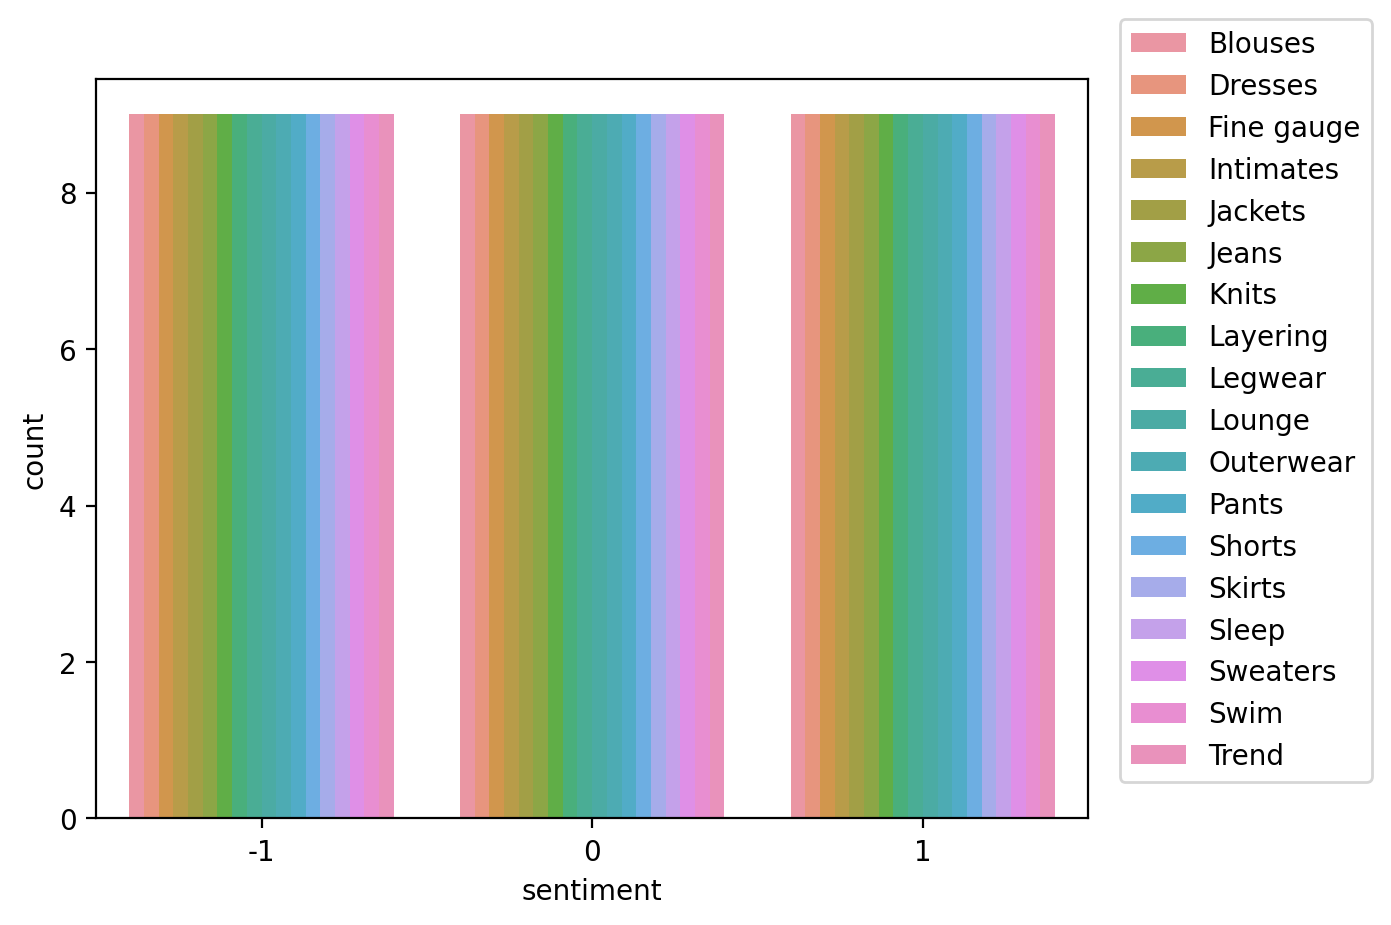

In [25]:
import seaborn as sns

sns.countplot(data=df_balanced, x='sentiment', hue='product_category')

plt.legend(loc='upper right',bbox_to_anchor=(1.3, 1.1))


<a name='c1w2-4.'></a>
# 4. Analyze bias on balanced dataset with Amazon SageMaker Clarify
Let's analyze bias in `sentiment` with respect to the `product_category` facet on your balanced dataset.

Save and upload balanced data to S3 bucket.

In [26]:
path_balanced = './womens_clothing_ecommerce_reviews_balanced.csv'
df_balanced.to_csv(path_balanced, index=False, header=True)

data_s3_uri_balanced = sess.upload_data(bucket=bucket, key_prefix='bias/balanced', path=path_balanced)
data_s3_uri_balanced

's3://sagemaker-us-east-1-096488525855/bias/balanced/womens_clothing_ecommerce_reviews_balanced.csv'

You can review the uploaded CSV file in the S3 bucket and prefix `bias/balanced`.

In [27]:
from IPython.core.display import display, HTML

display(HTML('<b>Review <a target="top" href="https://s3.console.aws.amazon.com/s3/home?region={}#">Amazon S3 bucket</a></b>'.format(region)))

/tmp/ipykernel_18/1620809557.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


<a name='c1w2-4.1.'></a>
### 4.1. Configure a `DataConfig`

In [28]:
from sagemaker import clarify

bias_report_balanced_output_path = 's3://{}/bias/generated_bias_report/balanced'.format(bucket)

data_config_balanced = clarify.DataConfig(
    ### BEGIN SOLUTION - DO NOT delete this comment for grading purposes
    s3_data_input_path=data_s3_uri_balanced, # Replace None
    s3_output_path=bias_report_balanced_output_path, # Replace None
    label='sentiment', # Replace None
    ### END SOLUTION - DO NOT delete this comment for grading purposes
    headers=df_balanced.columns.to_list(),
    dataset_type='text/csv'
)

<a name='c1w2-4.2.'></a>
### 4.2. Configure `BiasConfig`

`BiasConfig` for the balanced dataset will have the same settings as before.

In [29]:
bias_config_balanced = clarify.BiasConfig(
    label_values_or_threshold=[1], # desired sentiment
    facet_name='product_category' # sensitive column (facet)
)

<a name='c1w2-4.3.'></a>
### 4.3. Configure SageMaker Clarify as a processing job

`SageMakerClarifyProcessor` object will also have the same parameters.

In [30]:
clarify_processor_balanced = clarify.SageMakerClarifyProcessor(role=role,
                                                      instance_count=1,
                                                      instance_type='ml.m5.large',
                                                      sagemaker_session=sess)

<a name='c1w2-4.4.'></a>
### 4.4. Run the Amazon SageMaker Clarify processing job

In [31]:
clarify_processor_balanced.run_pre_training_bias(
    ### BEGIN SOLUTION - DO NOT delete this comment for grading purposes
    data_config=data_config_balanced, # Replace None
    data_bias_config=bias_config_balanced, # Replace None
    ### END SOLUTION - DO NOT delete this comment for grading purposes
    methods=["CI", "DPL", "KL", "JS", "LP", "TVD", "KS"],
    wait=False,
    logs=False
)


Job Name:  Clarify-Pretraining-Bias-2023-12-30-05-42-40-023
Inputs:  [{'InputName': 'dataset', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-east-1-096488525855/bias/balanced/womens_clothing_ecommerce_reviews_balanced.csv', 'LocalPath': '/opt/ml/processing/input/data', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}, {'InputName': 'analysis_config', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-east-1-096488525855/bias/generated_bias_report/balanced/analysis_config.json', 'LocalPath': '/opt/ml/processing/input/config', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}]
Outputs:  [{'OutputName': 'analysis_result', 'AppManaged': False, 'S3Output': {'S3Uri': 's3://sagemaker-us-east-1-096488525855/bias/generated_bias_report/balanced', 'LocalPath': '/opt/ml/processing/output', 'S3UploadMode': 'EndOfJob'}}]


In [32]:
run_balanced_bias_processing_job_name = clarify_processor_balanced.latest_job.job_name
print(run_balanced_bias_processing_job_name)

Clarify-Pretraining-Bias-2023-12-30-05-42-40-023


<a name='c1w2-4.5.'></a>
### 4.5. Run and review the Clarify processing job on the balanced dataset
Review the results of the run following the links:

In [33]:
from IPython.core.display import display, HTML

display(HTML('<b>Review <a target="blank" href="https://console.aws.amazon.com/sagemaker/home?region={}#/processing-jobs/{}">processing job</a></b>'.format(region, run_balanced_bias_processing_job_name)))


/tmp/ipykernel_18/1646316303.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [34]:
from IPython.core.display import display, HTML

display(HTML('<b>Review <a target="blank" href="https://console.aws.amazon.com/cloudwatch/home?region={}#logStream:group=/aws/sagemaker/ProcessingJobs;prefix={};streamFilter=typeLogStreamPrefix">CloudWatch logs</a> after about 5 minutes</b>'.format(region, run_balanced_bias_processing_job_name)))


/tmp/ipykernel_18/531247137.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [35]:
running_processor = sagemaker.processing.ProcessingJob.from_processing_name(processing_job_name=run_balanced_bias_processing_job_name,
                                                                            sagemaker_session=sess)

### _This cell will take approximately 5-10 minutes to run._

In [36]:
%%time

running_processor.wait(logs=False)

............................................................................!CPU times: user 226 ms, sys: 37.9 ms, total: 264 ms
Wall time: 6min 25s


<a name='c1w2-4.6.'></a>
### 4.6. Analyze balanced bias report

List the files in the output path `bias_report_balanced_output_path`:

In [37]:
!aws s3 ls $bias_report_balanced_output_path/

2023-12-30 05:49:02      29889 analysis.json
2023-12-30 05:42:41        346 analysis_config.json
2023-12-30 05:49:02    1231056 report.html
2023-12-30 05:49:02     970849 report.ipynb
2023-12-30 05:49:02     858966 report.pdf


Download generated bias report from S3 bucket:

In [38]:
!aws s3 cp --recursive $bias_report_balanced_output_path ./generated_bias_report/balanced/

download: s3://sagemaker-us-east-1-096488525855/bias/generated_bias_report/balanced/analysis_config.json to generated_bias_report/balanced/analysis_config.json
download: s3://sagemaker-us-east-1-096488525855/bias/generated_bias_report/balanced/analysis.json to generated_bias_report/balanced/analysis.json
download: s3://sagemaker-us-east-1-096488525855/bias/generated_bias_report/balanced/report.html to generated_bias_report/balanced/report.html
download: s3://sagemaker-us-east-1-096488525855/bias/generated_bias_report/balanced/report.pdf to generated_bias_report/balanced/report.pdf
download: s3://sagemaker-us-east-1-096488525855/bias/generated_bias_report/balanced/report.ipynb to generated_bias_report/balanced/report.ipynb


Review the downloaded bias report (in HTML format):

In [39]:
from IPython.core.display import display, HTML

display(HTML('<b>Review <a target="blank" href="./generated_bias_report/balanced/report.html">balanced bias report</a></b>'))

/tmp/ipykernel_18/1655752658.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In this run, you analyzed bias for `sentiment` relative to the `product_category` for the balanced data.  Note that the Class Imbalance (CI) metric is equal across all product categories for the target label, `sentiment`. And Difference in Positive Proportions in Labels (DPL) metric values are zero.